# Project CV - Pneumonia Detection

+ `Maximilian Mörth: if22b190`
+ `Alan Pisazka: if20b141`

DataSet: https://data.mendeley.com/datasets/rscbjbr9sj/3

## Dataset

>- How does the project relate to real applications?
>    - Pneumonia detection using computer vision has real-world applications in healthcare, particularly in radiology. It can assist radiologists and healthcare providers in quickly and accurately diagnosing pneumonia by analyzing chest X-rays or CT scans.
>    - The project can be used in hospitals and clinics to aid medical professionals in the triage of patients and can be part of telemedicine solutions for remote diagnosis.
>- Describe the dataset (Was it balanced? What was the imaging source? Etc.)
>- How does the project relate to real applications?
>- Which problems did you encounter and how did you solve them?
>- Describe what you did and why you did it!

## Practical Part

### 0. Preparation

#### 0.0 Install Dependencies

In [1]:
%%capture # suppress output
!pip install numpy torch matplotlib; # install dependencies

#### 0.1 Import Librarys

In [2]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# (CV) Libraries for Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#### 0.1 Settings

In [17]:
# Path to data
data_dir = 'ZhangLabData/CellData/chest_xray/'

CNN Configuration
1. `image_size = 224`: This line is setting the variable `image_size` to 224. This represents the height and width of the images that the model will be processing. Images inputted into the model are often resized to ensure they all have the same dimensions. In this case, all images would be resized to 224x224 pixels.

2. `batch_size = 32`: A batch size refers to the number of training examples utilized in one iteration. In this case, a mini-batch gradient descent is being used with a batch size of 32.

3. `num_epochs = 10`: An epoch is the number of passes of the entire training dataset the machine learning algorithm has completed. If the batch size is the entire dataset then the number of epochs is effectively the number of iterations. In this case, the model will be trained over 10 epochs, meaning it will see each training example 10 times.

4. `torch.device(...)`: This line is creating a PyTorch device, which is a object representing the device where a PyTorch tensor will be allocated. The device will be the first CUDA device if a CUDA device is available, otherwise it will be the CPU. CUDA is a parallel computing platform and API model created by NVIDIA, which allows developers to use NVIDIA GPUs for general purpose processing. The `torch.cuda.is_available()` function checks if there is a CUDA device available. If there is, `"cuda:0"` is used, which represents the first CUDA device. If there isn't, `"cpu"` is used by default, which represents the CPU.

In [4]:
image_size = 224
batch_size = 32
num_epochs = 10

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 1. Loading the Image Dataset

#### 1.1 Data Transforms / Data Augmentation

The Code below defines a dictionary `data_transforms` for image preprocessing. It applies different transformations to training and validation datasets, such as resizing, cropping, flipping, converting to tensors, and normalizing.

The dictionary has two keys: `'train'` and `'val'`, which stand for the training and validation datasets respectively. Each key is associated with a series of transformations, defined using `transforms.Compose([])`, which will be applied to the images in the corresponding dataset.

For the `'train'` dataset:

1. `transforms.RandomResizedCrop(image_size)`: This randomly crops the image to a given size. The randomness introduces variability and helps prevent overfitting.
2. `transforms.RandomHorizontalFlip()`: This randomly flips the image horizontally. Again, this introduces variability and helps prevent overfitting.
3. `transforms.ToTensor()`: This converts the image from a PIL Image format to a PyTorch tensor.
4. `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: This normalizes the tensor image with mean and standard deviation. These values are standard for pre-trained models provided by torchvision.

For the `'val'` dataset:

1. `transforms.Resize(image_size)`: This resizes the image to the given size.
2. `transforms.CenterCrop(image_size)`: This crops the image at the center to the given size.
3. `transforms.ToTensor()`: This converts the image from a PIL Image format to a PyTorch tensor.
4. `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: This normalizes the tensor image with mean and standard deviation. These values are standard for pre-trained models provided by torchvision.

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#### 1.2 Loading the Data
This code is creating a training dataset and a testing dataset from images stored in the 'train' and 'test' subdirectories of data_dir, and it's applying the appropriate transformations to each image in these datasets.

Followed by creating a training data loader and a testing data loader from the previously created datasets, specifying the batch size, whether to shuffle the data, and the number of workers to use for data loading. (subprocesses)

In [7]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### 2. Exploring the Data / Visualize

The function `show_images(data_loader, num_images)` displays a specified number of images from a given data loader. The function extracts class names, creates an iterator for the data loader, retrieves the first batch of images and labels, and then displays the images with their corresponding class names. In our case, we limited the function to display the first 10 images from the `train_loader`.

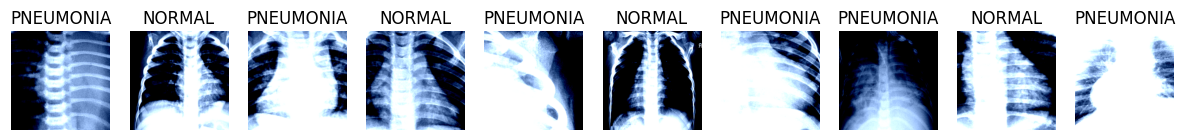

In [19]:
def show_images(data_loader, num_images):
    class_names = data_loader.dataset.classes
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    images = images.clamp(0, 1)  # Fix for "Clipping input data" warning

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].permute(1, 2, 0))
        ax.set_title(class_names[labels[idx]])
        ax.axis('off')

    plt.show()

show_images(train_loader, 10)

### 3. Model building / training

#### 3.1 Build the Model
The code below defines a custom Convolutional Neural Network (CNN) model for a binary classification task, for diagnosing pneumonia from medical images. The model is defined as a class `PneumoniaCNN` that inherits from `nn.Module`, which is the base class for all neural network modules in PyTorch.

In the `__init__` method, the layers of the neural network are defined:

1. `self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)`: This is the first convolutional layer of the network. It takes an input with 3 channels (likely a color image) and applies 32 filters. The kernel size is 3, meaning the filters are 3x3 pixels, and padding is set to 1 to keep the spatial dimensions of the output the same as the input.

2. `self.pool = nn.MaxPool2d(2, 2)`: This is a max pooling layer with a 2x2 window and stride of 2. Max pooling is used to reduce the spatial dimensions of the output from the previous layer.

3. `self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)`: This is the second convolutional layer of the network. It takes the 32-channel output from the previous layer and applies 64 filters.

4. `self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)`: This is the first fully connected layer of the network. It takes the flattened output from the previous layer and applies a linear transformation to produce an output of size 128.

5. `self.fc2 = nn.Linear(128, 2)`: This is the second fully connected layer of the network. It takes the 128-dimensional output from the previous layer and applies a linear transformation to produce the final output of size 2, corresponding to the two classes.

In the `forward` method, the forward pass of the neural network is defined. The input `x` is passed through each layer in turn, with the ReLU activation function applied after the convolutional layers and the first fully connected layer. The output from the second fully connected layer is returned as the final output of the network.

Finally, an instance of the `PneumoniaCNN` class is created and moved to the device defined earlier (either a GPU or CPU). This instance will be used for training and testing the model.

In [10]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = PneumoniaCNN()
model = model.to(device)

#### 3.2 Setup Loss Function and Optimizer

1. `criterion = nn.CrossEntropyLoss()`: This line is setting up the loss function for the model. The loss function is used to measure how well the model's predictions match the actual labels of the data. In this case, the Cross Entropy Loss is being used, which is a common choice for classification tasks. This loss function calculates the cross entropy between the model's predictions and the actual labels, and the model's goal during training is to minimize this loss.

2. `optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)`: This line is setting up the optimizer for the model. The optimizer is the algorithm used to update the model's parameters in order to minimize the loss. In this case, the Stochastic Gradient Descent (SGD) optimizer is being used. The `model.parameters()` function is passed to the optimizer to tell it which parameters to update. The learning rate `lr` is set to 0.001, which controls the step size during optimization. The `momentum` parameter is set to 0.9, which helps accelerate SGD in the relevant direction and dampens oscillations.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### 3.3 Model Training
The outer loop `for epoch in range(num_epochs):` runs the training process for a specified number of epochs. An epoch is one complete pass through the entire training dataset.

Inside this loop, `model.train()` is called to set the model to training mode. This is necessary because some layers, like dropout and batch normalization, behave differently during training and evaluation.

`running_loss` is initialized as a variable to keep track of the total loss for each epoch.

The inner loop `for inputs, labels in train_loader:` iterates over the training data loader. In each iteration, a batch of inputs and their corresponding labels are loaded.

`inputs, labels = inputs.to(device), labels.to(device)` moves the inputs and labels to the same device as the model. This is typically a GPU if one is available, as GPUs can significantly speed up the training process.

`optimizer.zero_grad()` resets the gradients of the model parameters. Gradients are reset because by default they accumulate (i.e., are summed up) over each batch.

`outputs = model(inputs)` feeds the inputs into the model and gets the outputs.

`loss = criterion(outputs, labels)` calculates the loss, which is a measure of how far the model's predictions are from the true values. The `criterion` is a loss function that was defined earlier.

`loss.backward()` computes the gradient of the loss with respect to the model parameters. This is done using backpropagation, which is an algorithm for efficiently calculating gradients in neural networks.

`optimizer.step()` updates the model parameters based on the gradients. This is a step in the direction that minimizes the loss.

`running_loss += loss.item()` adds the current loss to the running total. This is necessary for the calculation of the average loss!

In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 0.5004304460272556
Epoch 2, Loss: 0.44757145679578547
Epoch 3, Loss: 0.41565477389206246
Epoch 4, Loss: 0.4127558866833768
Epoch 5, Loss: 0.3816832721960254
Epoch 6, Loss: 0.36009838631967217
Epoch 7, Loss: 0.3621790966973072
Epoch 8, Loss: 0.3587418682873249
Epoch 9, Loss: 0.33146257930230805
Epoch 10, Loss: 0.3303874872806596


### 4. Results / Discussion

`model.eval()` is used to set the model to evaluation mode. This is important, because certain layers within the model, such as Dropout have different behaviours during traing and evaluation.

In [13]:
model.eval()

PneumoniaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

The following code is used to evaluating the accuracy of the trained CNN model on a test dataset.

The variables `correct` and `total` will be used to keep track of the number of correct predictions and the total number of predictions, respectively.

`with torch.no_grad():` is used to disable gradient calculations. This is done because during evaluation, we don't need to compute gradients, and disabling gradient calculations can save memory and speed up the process.

Again, inside this block, a loop `for inputs, labels in test_loader:` iterates over the test data loader. In each iteration, a batch of inputs and their corresponding labels are loaded.

`inputs, labels = inputs.to(device), labels.to(device)` moves the inputs and labels to the same device as the model. Like is was done in the training process before.

`outputs = model(inputs)` feeds the inputs into the model and gets the outputs. These outputs are the model's predictions.

`_, predicted = torch.max(outputs, 1)` gets the index of the maximum value in the outputs tensor along dimension 1 (which corresponds to the predicted class), and assigns it to the `predicted` variable.

`total += labels.size(0)` increments the total count by the number of labels in the current batch.

`correct += (predicted == labels).sum().item()` increments the correct count by the number of correct predictions in the current batch. This is done by comparing the predicted classes to the true classes, summing up the number of correct predictions, and adding this to the correct count.

After the loop, the accuracy of the model on the test dataset will be calculated as the percentage of correct predictions.

In [14]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 84.94%


In this cell, instead of calculating the accuracy, the model's predictions and the true labels are stored in two lists. These lists are then used to calculate the confusion matrix using the `confusion_matrix` function from `sklearn.metrics`. The confusion matrix provides a more detailed view of the model's performance, showing not only the number of correct predictions but also the types of errors made.

In [15]:
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(true_labels, predictions)


The following function `plot_confusion_matrix()` is used to plot the, already calculated, confusion matrix. 

The function takes the following input parameters:

1. `cm`: This is the confusion matrix that you want to plot. It should be a 2D array-like structure (like a list of lists or a numpy array), where the element at the i-th row and j-th column is the number of observations known to be in group i but predicted to be in group j.

2. `classes`: This is a list of the class names. The order of the class names should correspond to the order of the rows and columns in the confusion matrix.

3. `normalize` (optional): This is a boolean flag that determines whether to normalize the confusion matrix. If `True`, the confusion matrix will be normalized so that each row sums to 1. This can be useful to get a better understanding of the proportions of correct and incorrect predictions. The default value is `False`.

4. `title` (optional): This is the title of the plot. The default value is 'Confusion matrix'.

5. `cmap` (optional): This is the colormap used to color the cells of the confusion matrix. The default value is `plt.cm.Blues`, which is a blue colormap.

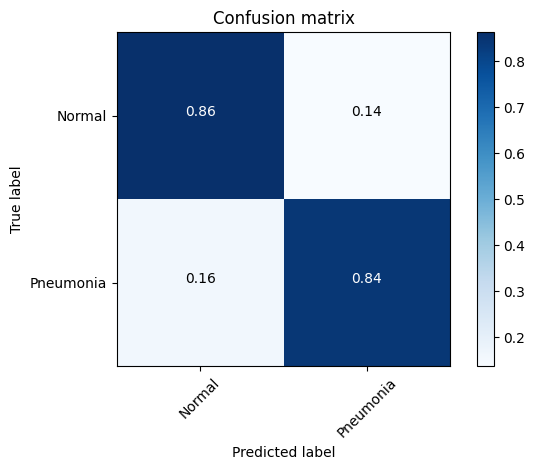

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=True)
plt.show()